Run through pre-processed files through Clustering Algorithms:
<br>1) KMeans
<br>2) Agglomerative Linkage: Ward
<br>3) Agglomerative Linkage: Complete

## Scale the values of the features - to be used as input for Clustering, and apply PCA for dimensionality reduction for visualization

The features where we found high correlation were selected to be used for further analysis:
- pitch+timbre - positive correlation
- valence+danceability - positive correlation
- energy+acousticness - negative correlation (high energy - low acoustic)
- energy+pitch - positive correlation

In [3]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [1]:
## Scale features before applying PCA.  Features in our dataframe our not standardized, we have some features which 
## are normalized, and some which are not.

from sklearn.preprocessing import StandardScaler


features = ['danceability', 'energy', 'acousticness', 'valence', 'pitch_med',  'timbre_med']

In [4]:
songsDF = pd.read_pickle('../data/Songs_input.p')

In [5]:
x = songsDF.loc[:, features].values
y = songsDF.loc[:, 'genre'].values

In [6]:
Xtr = StandardScaler().fit_transform(x)

In [7]:
from sklearn.decomposition import PCA

#### Determine number of components for PCA

In [8]:
pca = PCA(n_components=None).fit(Xtr)
components = pca.components_
ex_var = pca.explained_variance_ratio_

In [9]:
sums = ex_var.cumsum()
n_comps = 0
for i, s in enumerate(sums):
    if s > 0.9:
        n_comps = i
        break

In [10]:
n_comps

3

In [11]:
comp_range = range(pca.n_components_)

In [12]:
import numpy as np

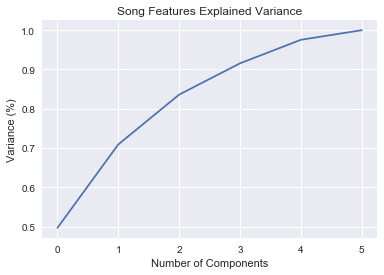

In [13]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Song Features Explained Variance')
plt.show()

In [14]:
data_scaled = pd.DataFrame(Xtr, columns = features)

In [15]:
# transform dataset using n_comps = 3
pca = PCA(n_components=3).fit(Xtr)
x = pca.transform(Xtr)

In [16]:
pca3 = pd.DataFrame(pca.components_, columns=data_scaled.columns, index=['PC-1','PC-2','PC-3']).T
pca3

PC-1      PC-2      PC-3
danceability -0.164489 -0.766859 -0.211481
energy       -0.522465  0.244085 -0.135654
acousticness  0.445688 -0.268657  0.298748
valence      -0.393544 -0.475016 -0.117408
pitch_med    -0.485263  0.208217 -0.038967
timbre_med   -0.333135 -0.105732  0.912316

### Perform clustering on scaled features Xtr

determine the optimum value of K for clustering

In [19]:
from sklearn.cluster import KMeans

In [20]:
def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [21]:
import numpy as np
kRange = range(1,12)
KmeanTopics = test(Xtr, kRange)

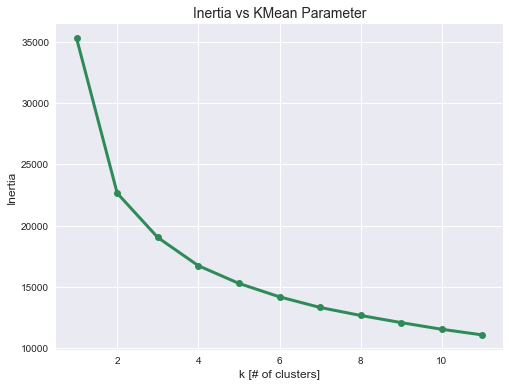

In [22]:
figInertiaWithK = plt.figure(figsize=(8,6))

plt.plot(kRange, KmeanTopics, 'o-', color='seagreen', linewidth=3)
plt.xlabel('k [# of clusters]', size=12)
plt.ylabel('Inertia', size=12)
plt.title('Inertia vs KMean Parameter', size=14)



Let us apply KMeans clustering algorithms using the transformed features and see what patterns/clusters this gives us. 

## KMeans clustering (K = 3) using Scaled features Xtr

In [23]:
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n3'] = cluster_labels

In [24]:
songsDF['pca1'] = x[:,0]
songsDF['pca2'] = x[:,1]
songsDF['pca3'] = x[:,2]


In [25]:
c1 = songsDF[songsDF.K_cluster_n3 == 0]
c2 = songsDF[songsDF.K_cluster_n3 == 1]
c3 = songsDF[songsDF.K_cluster_n3 == 2]


### Plotting first 3 components from transformed dataset to visualize the resulting clusters

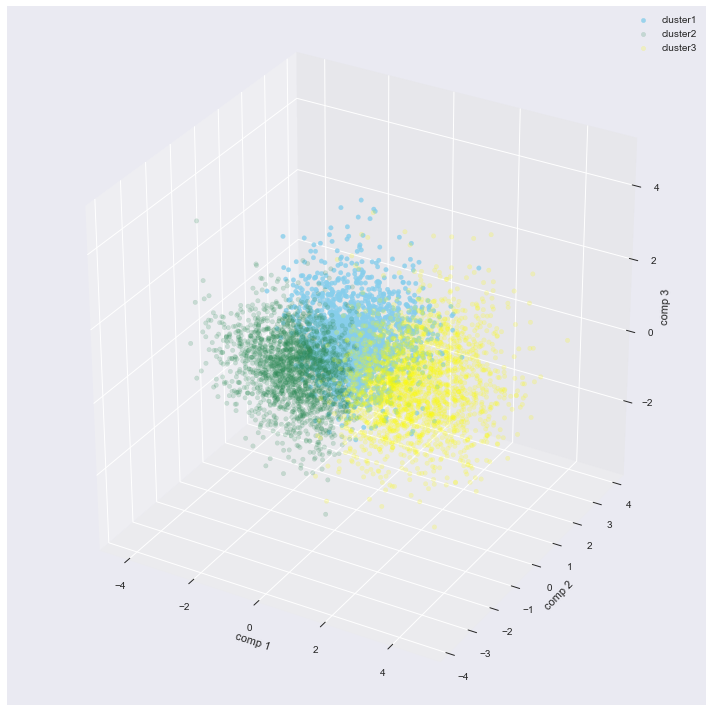

In [26]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(c1['pca1'], c1['pca2'], c1['pca3'], color='skyblue', alpha=0.8, label='cluster1')
p = ax.scatter(c2['pca1'], c2['pca2'], c2['pca3'], color='seagreen', alpha=0.2, label='cluster2')
p = ax.scatter(c3['pca1'], c3['pca2'], c3['pca3'], color='yellow', alpha=0.2, label='cluster3')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_N6.png')


In [27]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

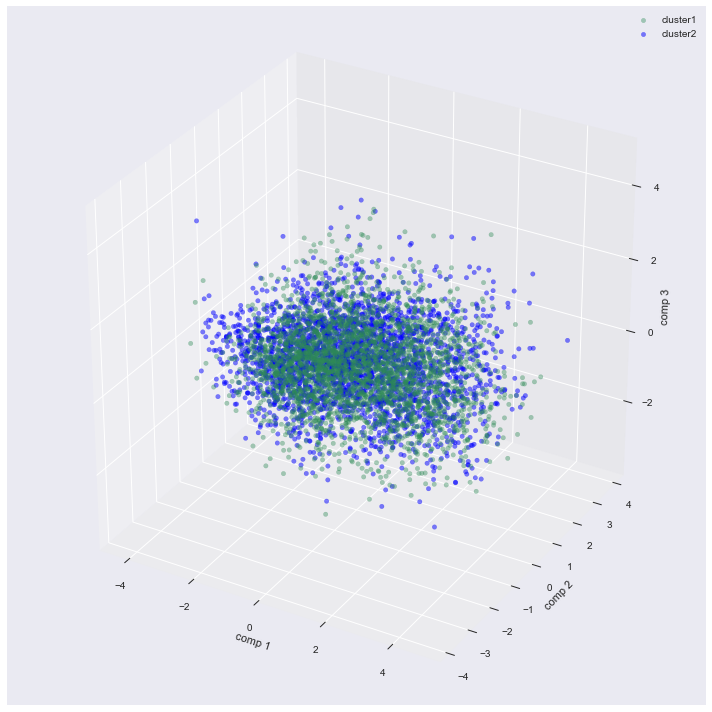

In [28]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(country['pca1'], country['pca2'], country['pca3'], color='seagreen', alpha=0.4, label='cluster1')
p = ax.scatter(pop['pca1'], pop['pca2'], pop['pca3'], color='blue', alpha=0.5, label='cluster2')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_CountryPop.png')


## Looking deeper into the resulting cluster features:

Scale the timbre_med column so that it is within 0 to 1 range

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
songsDF['timbre_med_scaled'] = scaler.fit_transform(songsDF[['timbre_med']])

In [38]:
def clustSummary(col, k):
    clust_summ = {'group':[], 'danceability':[], 'energy':[],
                  'acousticness': [], 'valence': [], 'pitch':[], 'timbre':[]}

    for num in range(k):
        clust_summ['group'].append('Cluster{}'.format(num))
        clust_summ['danceability'].append(songsDF[songsDF[col] == num]['danceability'].median())
        clust_summ['energy'].append(songsDF[songsDF[col] == num]['energy'].median())
        clust_summ['acousticness'].append(songsDF[songsDF[col] == num]['acousticness'].median())
        clust_summ['valence'].append(songsDF[songsDF[col] == num]['valence'].median())
        clust_summ['pitch'].append(songsDF[songsDF[col] == num]['pitch_med'].median())
        clust_summ['timbre'].append(songsDF[songsDF[col] == num]['timbre_med_scaled'].median())
        
    return clust_summ;

In [39]:
KM3_clust_df = pd.DataFrame(clustSummary('K_cluster_n3',3))[['group','danceability','energy','acousticness','valence','pitch','timbre']]
KM3_clust_df

group  danceability  energy  acousticness  valence   pitch    timbre
0  Cluster0         0.448   0.786        0.0198    0.398  0.2310  0.420202
1  Cluster1         0.642   0.732        0.1080    0.726  0.2365  0.467765
2  Cluster2         0.517   0.350        0.6730    0.263  0.1315  0.349806

Create Spider plot to visualize the three clusters identified by K-Means

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [214]:
def make_spider( row, title, color):
 
    # number of variable
    categories=list(KM_clust_df)[1:]
    N = len(categories)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(15,8))
    
    # Initialise the spider plot
    ax = plt.subplot(1,3,row+1, polar=True, )
    #ax = plt.subplot(110+(row+1), polar=True, )
 
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(np.linspace(-1,1,10), [str(x) for x in np.linspace(-1,1,10)], color="grey", size=7)
    plt.ylim(0,1)
 
    # Ind1
    values=KM_clust_df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
 
    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
 
    my_palette = plt.cm.get_cmap("Set2", len(KM_clust_df.index))
    
    for row in range(0, len(KM_clust_df.index)):
        make_spider( row=row, title='group '+KM_clust_df['group'][row], color=my_palette(row))


In [215]:
# ------- PART 2: Apply to all individuals
# initialize the figure
#my_dpi=96
#plt.figure(figsize=(115,115))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(KM_clust_df.index))



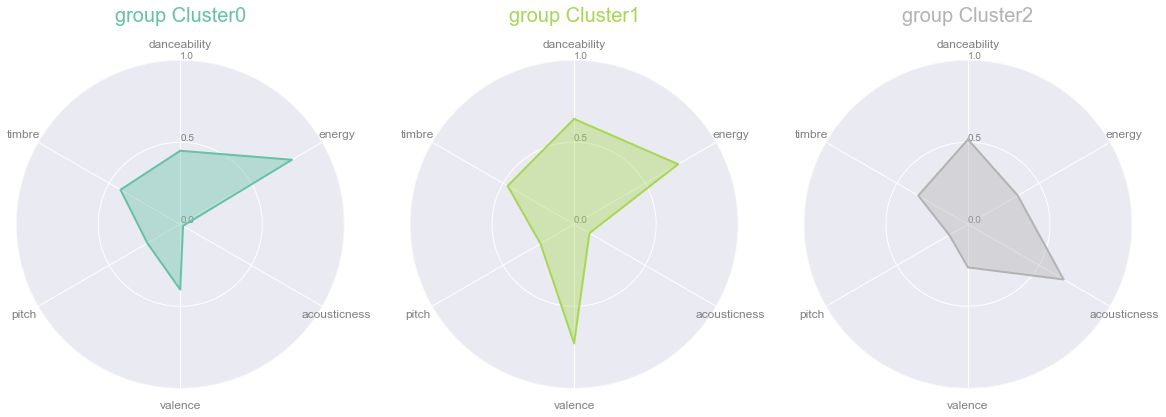

In [219]:
my_palette = plt.cm.get_cmap("Set2", len(KM_clust_df.index))

plt.figure(figsize=(20,8))

for row in range(0, len(KM_clust_df.index)):
    #make_spider( row=row, title='group '+KM_clust_df['group'][row], color=my_palette(row))
        # number of variable
    categories=list(KM_clust_df)[1:]
    N = len(categories)
    title='group '+KM_clust_df['group'][row]
    color=my_palette(row)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    

    
    # Initialise the spider plot
    ax = plt.subplot(1,3,row+1, polar=True, )
    #ax = plt.subplot(110+(row+1), polar=True, )
 
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=12)
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(np.linspace(-1.0,1.0,5), [str(x) for x in np.linspace(-1.0,1.0,5)], color="grey", size=10)
    plt.ylim(0,1)
 
    # Ind1
    values=KM_clust_df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
 
    # Add a title
    plt.title(title, size=11, color=color, y=1.1, fontsize=20)

### Cluster Summary - KMeans (k=3)

<br> __Cluster 0__ - high energy, low valence, high pitch, low acoustic
<br> __Cluster 1__ - High energy, high danceability, high valence, high timbre
<br> __Cluster 2__ - lower energy, high acoustic, lowest valence, low timbre, low pitch

###  Cluster 0

<br>[Celine Dion    Can't Fight the Feeling-2007](https://www.youtube.com/watch?v=88SXDM68fl4)      [Martina McBride So Magical - 2003](https://www.youtube.com/watch?v=sgBqG3bRH7I)
<br>[Britney Spears Touch of My Hand 2003](https://www.youtube.com/watch?v=-SnQcYcG41U)
[Billy Currington That's Just Me     2003](https://www.youtube.com/watch?v=SqkmGGii6ZI)
<br>[One Republic   Apologize 2007](https://www.youtube.com/watch?v=ZSM3w1v-A_Y)
[Keith Urban   Raining on Sunday  2002](https://www.youtube.com/watch?v=DgV7RG9Qgvk)

### Cluster 1

[Christina Aguilera Ain't No Other Man 2006](https://www.youtube.com/watch?v=8x7Ta89QLo4)
<br>[Whitney Houston I'm Every Woman 1992]
<br>[Justin Bieber Runaway Love 2010] 

[Billy Currington  Ain't What it Used to Be 2003](https://www.youtube.com/watch?v=AgUGUrD5zc4)
<br> [Rascal Flatts     Fast Cars and Freedom  2004](https://www.youtube.com/watch?v=ZsilfOVRX3U)
<br>[Martina McBride   Heart Trouble 1993]

### Cluster 2

<br>Christina Aguilera  Walk Away 2002
<br>Beyonce Dangerously in Love  2003
<br>Leona Lewis My Hands 2009

<br>Rascal Flats  Bless the Broken Road 2004
<br>Keith Urban   The Hard Way 2004
<br>Lady Antebellum  American Honey 2009

### Cluster 0 - high energy, low valence, high pitch, low acoustic

In [31]:
songsDF[songsDF.K_cluster_n3 == 0][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   1809.000000  1809.000000   1809.000000  1809.000000  1809.000000   
mean       0.437602     0.771189      0.080596     0.403753     0.246945   
std        0.112212     0.144555      0.129136     0.164705     0.074600   
min        0.000000     0.000063      0.000002     0.000000     0.095250   
25%        0.366000     0.663000      0.001190     0.280000     0.189250   
50%        0.448000     0.786000      0.019800     0.398000     0.231000   
75%        0.519000     0.894000      0.110000     0.519000     0.298500   
max        0.733000     0.999000      0.989000     0.965000     0.547000   

        timbre_med  
count  1809.000000  
mean      0.293282  
std       2.578910  
min      -8.877000  
25%      -1.359750  
50%       0.250000  
75%       1.920500  
max       9.700500

### Cluster 1 - High energy, high danceability, high valence, high timbre

In [37]:
songsDF[songsDF.K_cluster_n3 == 1][features ].describe() 

danceability       energy  acousticness      valence    pitch_med  \
count   1994.000000  1994.000000   1994.000000  1994.000000  1994.000000   
mean       0.649138     0.716218      0.185554     0.715954     0.240980   
std        0.094640     0.159070      0.205722     0.152384     0.060456   
min        0.321000     0.071100      0.000009     0.178000     0.076500   
25%        0.584250     0.602000      0.025725     0.608000     0.197000   
50%        0.642000     0.732000      0.108000     0.726000     0.236500   
75%        0.708000     0.845000      0.280000     0.838000     0.278875   
max        0.938000     0.999000      0.992000     0.982000     0.477250   

        timbre_med  
count  1994.000000  
mean      1.829209  
std       2.906276  
min      -9.486500  
25%      -0.109438  
50%       1.781000  
75%       3.744500  
max      18.913250

### Cluster 2 - lower energy, high acoustic, lowest valence, low timbre, low pitch

In [38]:
songsDF[songsDF.K_cluster_n3 == 2][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   2078.000000  2078.000000   2078.000000  2078.000000  2078.000000   
mean       0.499639     0.343905      0.617959     0.292769     0.134932   
std        0.137865     0.139952      0.269359     0.164111     0.040041   
min        0.000000     0.000020      0.000002     0.000000     0.036250   
25%        0.409000     0.244000      0.430250     0.169250     0.106813   
50%        0.517000     0.350000      0.673000     0.263000     0.131500   
75%        0.598000     0.446000      0.844000     0.390750     0.159500   
max        0.883000     0.789000      0.996000     0.966000     0.311750   

        timbre_med  
count  2078.000000  
mean     -2.007828  
std       3.296216  
min     -13.276000  
25%      -4.156937  
50%      -2.016000  
75%       0.066625  
max      13.745000

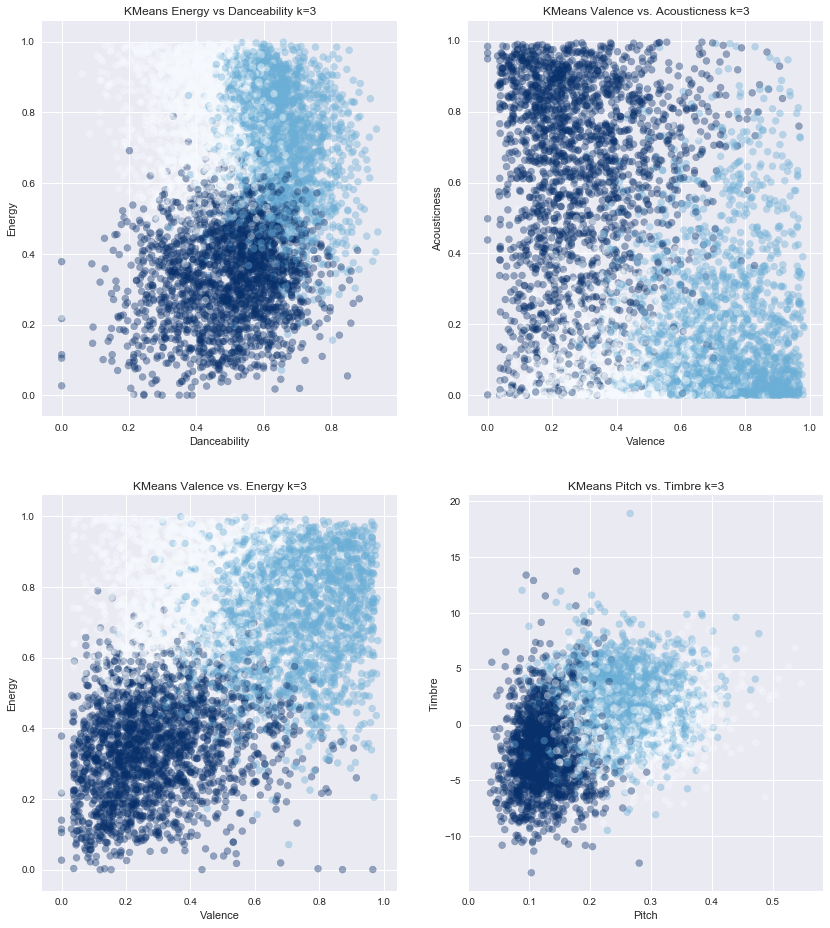

In [127]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K3.png')

## Let us explore how the clusters will be divided if we just create two clusters

In [35]:
km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n2'] = cluster_labels

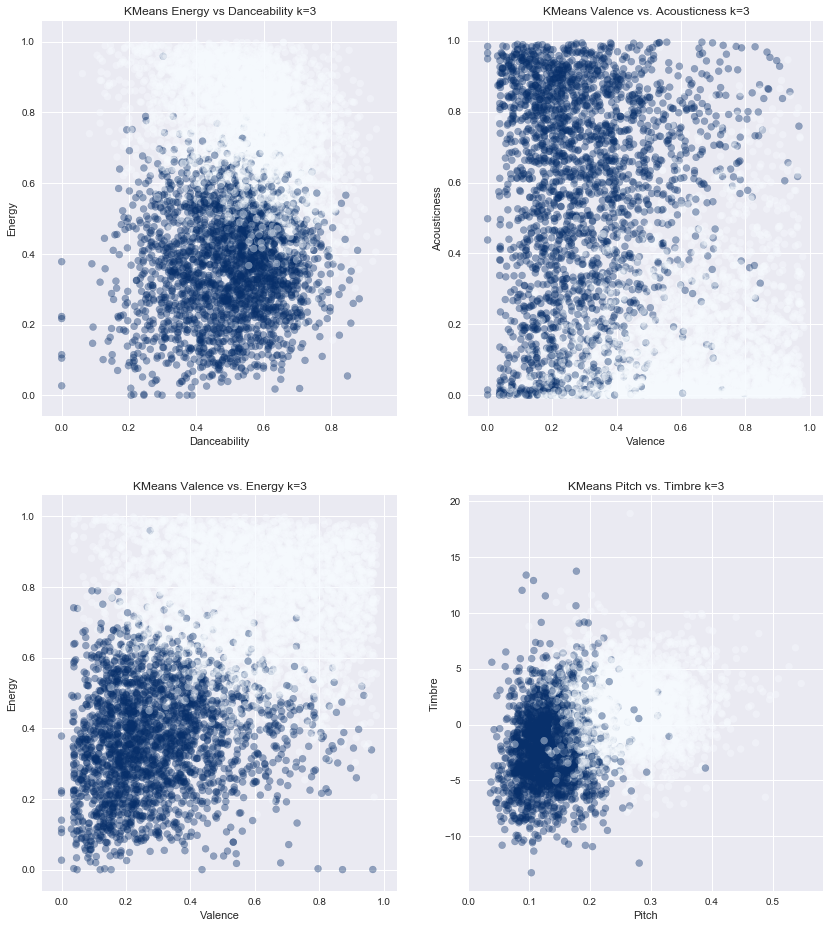

In [36]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K2.png')

In [40]:
KM2_clust_df = pd.DataFrame(clustSummary('K_cluster_n2',2))[['group','danceability','energy','acousticness','valence','pitch','timbre']]
KM2_clust_df

group  danceability  energy  acousticness  valence   pitch    timbre
0  Cluster0         0.566   0.775        0.0516    0.590  0.2405  0.446298
1  Cluster1         0.508   0.371        0.6310    0.266  0.1370  0.356792

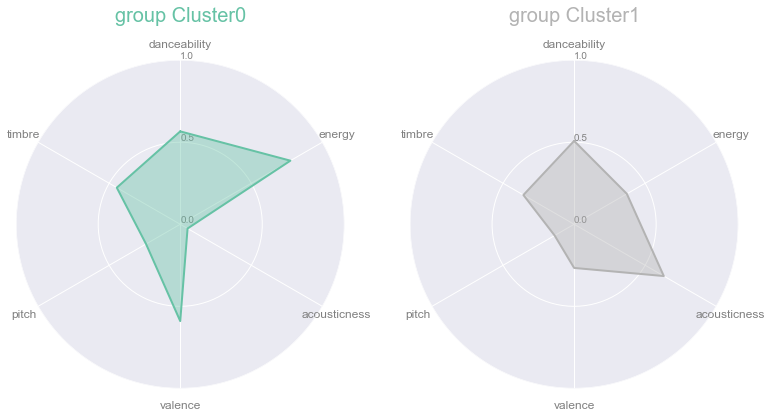

In [224]:
my_palette = plt.cm.get_cmap("Set2", len(KM_clust_df.index))

plt.figure(figsize=(20,8))

for row in range(0, len(KM_clust_df.index)):
    #make_spider( row=row, title='group '+KM_clust_df['group'][row], color=my_palette(row))
        # number of variable
    categories=list(KM_clust_df)[1:]
    N = len(categories)
    title='group '+KM_clust_df['group'][row]
    color=my_palette(row)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    

    
    # Initialise the spider plot
    ax = plt.subplot(1,3,row+1, polar=True, )
    #ax = plt.subplot(110+(row+1), polar=True, )
 
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=12)
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(np.linspace(-1.0,1.0,5), [str(x) for x in np.linspace(-1.0,1.0,5)], color="grey", size=10)
    plt.ylim(0,1)
 
    # Ind1
    values=KM_clust_df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
 
    # Add a title
    plt.title(title, size=11, color=color, y=1.1, fontsize=20)

In [42]:
songsDF[songsDF.K_cluster_n2 == 0][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   3517.000000  3517.000000   3517.000000  3517.000000  3517.000000   
mean       0.555537     0.758273      0.126348     0.585836     0.249626   
std        0.144908     0.146161      0.170523     0.212113     0.066199   
min        0.061500     0.156000      0.000002     0.032800     0.076500   
25%        0.467000     0.658000      0.005260     0.424000     0.200000   
50%        0.566000     0.775000      0.051600     0.590000     0.240500   
75%        0.652000     0.878000      0.184000     0.753000     0.291500   
max        0.938000     0.999000      0.992000     0.982000     0.547000   

        timbre_med  
count  3517.000000  
mean      1.232198  
std       2.811339  
min      -8.076000  
25%      -0.663500  
50%       1.090000  
75%       3.043000  
max      18.913250

In [43]:
songsDF[songsDF.K_cluster_n2 == 1][features ].describe() 

danceability       energy  acousticness      valence    pitch_med  \
count   2364.000000  2364.000000   2364.000000  2364.000000  2364.000000   
mean       0.495106     0.368446      0.573412     0.298643     0.139463   
std        0.140662     0.152779      0.293434     0.172486     0.041532   
min        0.000000     0.000020      0.000002     0.000000     0.036250   
25%        0.400000     0.260000      0.340750     0.172000     0.110500   
50%        0.508000     0.371000      0.631000     0.266000     0.137000   
75%        0.596000     0.478000      0.830000     0.393250     0.165000   
max        0.883000     0.959000      0.996000     0.966000     0.389500   

        timbre_med  
count  2364.000000  
mean     -1.830760  
std       3.290001  
min     -13.276000  
25%      -3.955938  
50%      -1.791125  
75%       0.224688  
max      13.745000

In [41]:
num_songs = 300

In [42]:
country = songsDF[songsDF.genre == 'country']
pop = songsDF[songsDF.genre == 'pop']

In [43]:
Top_songs = songsDF[songsDF.artist_hotttnesss > 0.5].sort_values('song_id', ascending=False).head(num_songs)

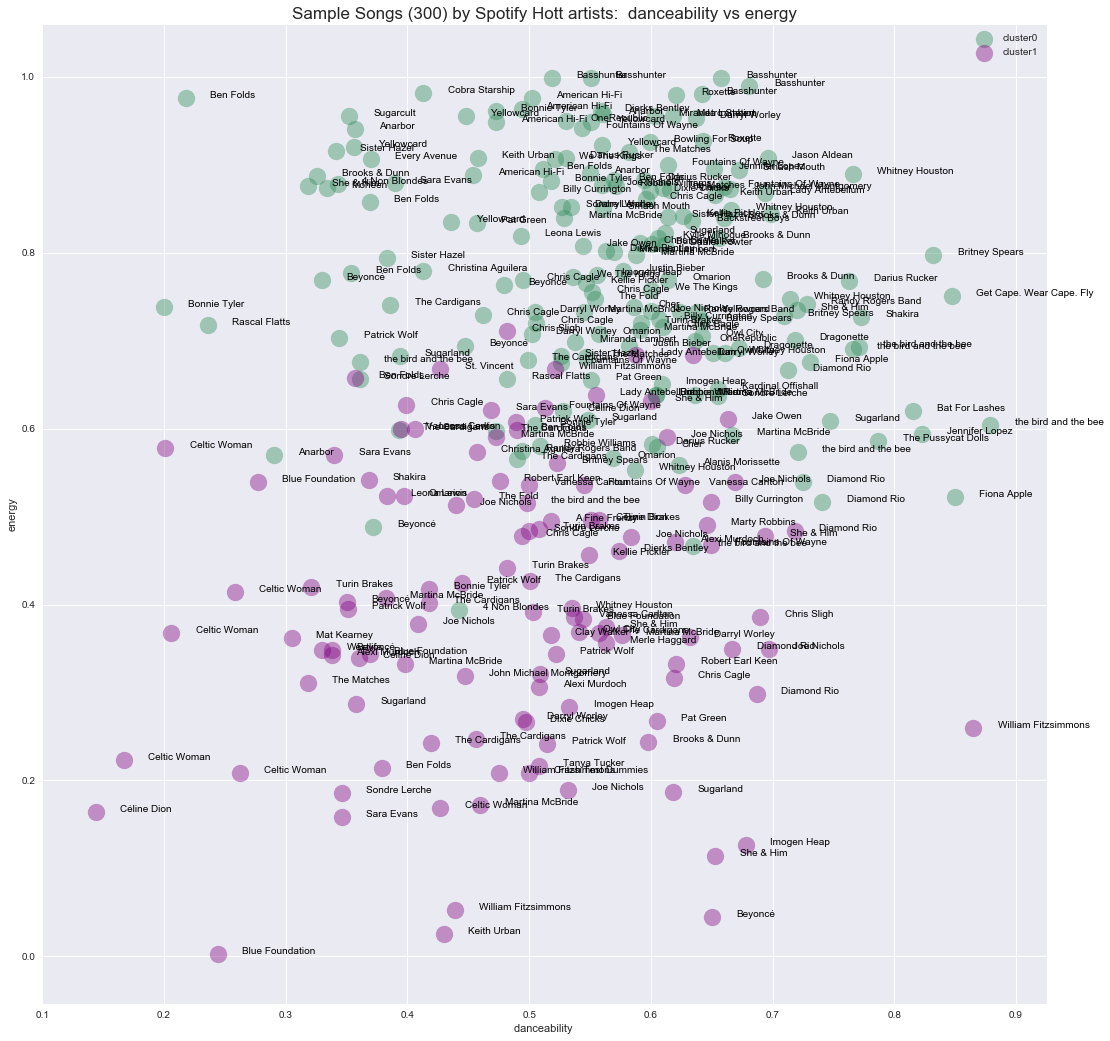

In [44]:
fig = plt.figure(figsize=(18,18))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='danceability', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='danceability', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3 == 2] ,x='danceability', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.danceability.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='medium',color='black')
p1.set_xlabel('danceability ')
p1.set_ylabel('energy')
plt.legend()
p1.set_title('Sample Songs ({}) by Spotify Hott artists:  danceability vs energy'.format(num_songs), fontsize=17)
plt.savefig('../images/Songs_dance_energy_Kmeans.png')

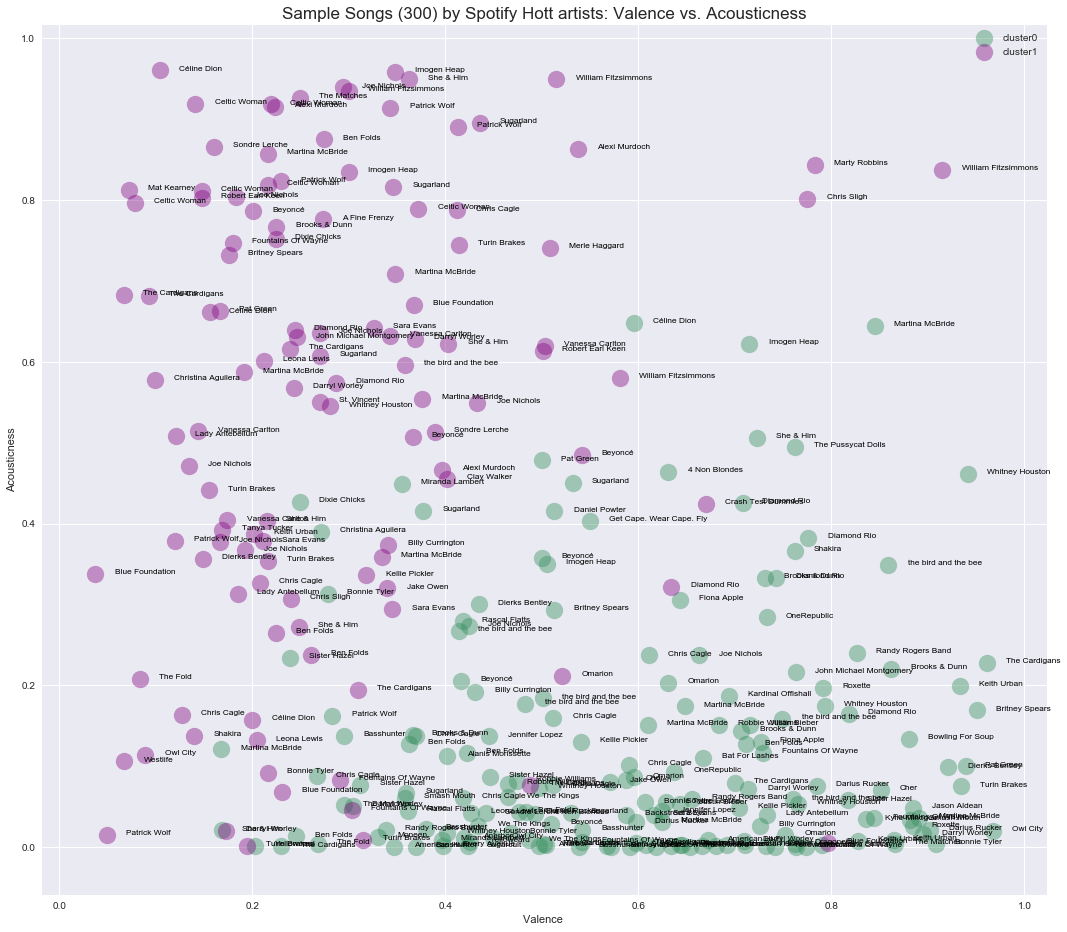

In [45]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')

for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.acousticness.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Acousticness')
plt.legend()
p1.set_title('Sample Songs ({}) by Spotify Hott artists: Valence vs. Acousticness'.format(num_songs), fontsize=17)
plt.savefig('../images/Songs_Valence_Acousticness_Kmeans.png')

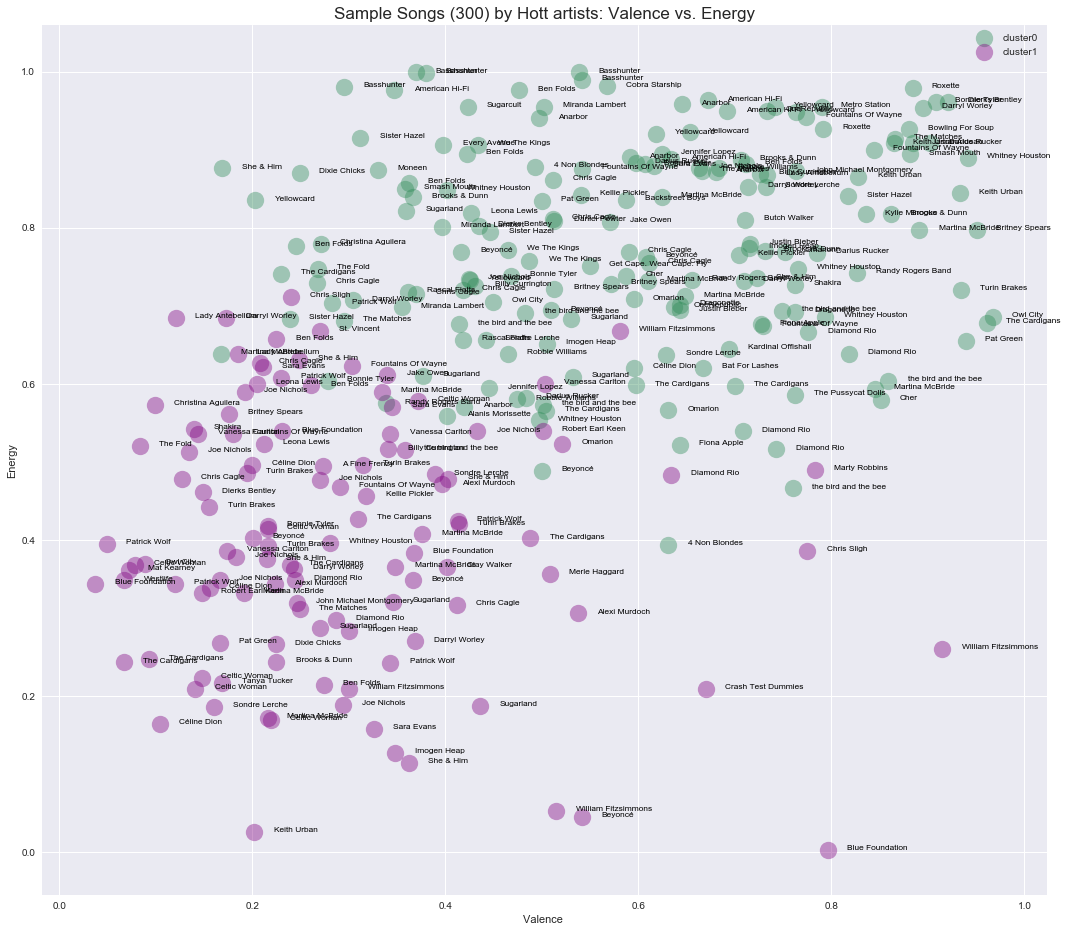

In [46]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3_9 == 2] ,x='valence', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Energy')
p1.set_title('Sample Songs ({}) by Hott artists: Valence vs. Energy'.format(num_songs), fontsize=17)
plt.legend()
plt.savefig('../images/Songs_Valence_Energy_Kmeans.png')

In [52]:
songsDF[(songsDF.artist_hotttnesss > 0.5) & (songsDF.K_cluster_n2 == 0)][['artist_name', 'title', 'genre']].sort_values('artist_name')

artist_name  \
424              4 Non Blondes   
425              4 Non Blondes   
426              4 Non Blondes   
427              4 Non Blondes   
428              4 Non Blondes   
429              4 Non Blondes   
430              4 Non Blondes   
431              4 Non Blondes   
423              4 Non Blondes   
1024             A Fine Frenzy   
1027             A Fine Frenzy   
1029             A Fine Frenzy   
1022             A Fine Frenzy   
1021             A Fine Frenzy   
1015             A Fine Frenzy   
1017             A Fine Frenzy   
613                Ace of Base   
612                Ace of Base   
611                Ace of Base   
610                Ace of Base   
609                Ace of Base   
608                Ace of Base   
614                Ace of Base   
607                Ace of Base   
3325                Afterhours   
5866         Alanis Morissette   
2310             Alexi Murdoch   
3150            American Hi-Fi   
3151            American Hi-Fi   
3155            American Hi-Fi   
3153            American Hi-Fi   
3154            American Hi-Fi   
3149            American Hi-Fi   
3152            American Hi-Fi   
3148            American Hi-Fi   
3141            American Hi-Fi   
3146            American Hi-Fi   
3147            American Hi-Fi   
3135            American Hi-Fi   
3136            American Hi-Fi   
3137            American Hi-Fi   
3138            American Hi-Fi   
3134            American Hi-Fi   
3140            American Hi-Fi   
3142            American Hi-Fi   
3143            American Hi-Fi   
3144            American Hi-Fi   
3139            American Hi-Fi   
1228                   Anarbor   
1229                   Anarbor   
1230                   Anarbor   
1231                   Anarbor   
1232                   Anarbor   
1233                   Anarbor   
1234                   Anarbor   
1235                   Anarbor   
1236                   Anarbor   
1238                   Anarbor   
1237                   Anarbor   
1240                   Anarbor   
1241                   Anarbor   
1242                   Anarbor   
1243                   Anarbor   
1239                   Anarbor   
2756           Backstreet Boys   
2753           Backstreet Boys   
2752           Backstreet Boys   
2750           Backstreet Boys   
2748           Backstreet Boys   
2746           Backstreet Boys   
2745           Backstreet Boys   
2744           Backstreet Boys   
2742           Backstreet Boys   
2757           Backstreet Boys   
2739           Backstreet Boys   
2738           Backstreet Boys   
2737           Backstreet Boys   
2736           Backstreet Boys   
2735           Backstreet Boys   
2731           Backstreet Boys   
2732           Backstreet Boys   
2743           Backstreet Boys   
2758           Backstreet Boys   
2734           Backstreet Boys   
2733           Backstreet Boys   
3971                Basshunter   
3973                Basshunter   
3972                Basshunter   
3970                Basshunter   
3969                Basshunter   
3968                Basshunter   
3967                Basshunter   
3966                Basshunter   
3965                Basshunter   
3964                Basshunter   
3959                Basshunter   
3962                Basshunter   
3961                Basshunter   
3960                Basshunter   
3963                Basshunter   
3958                Basshunter   
3957                Basshunter   
1286            Bat For Lashes   
1285            Bat For Lashes   
3605                 Ben Folds   
3587                 Ben Folds   
3585                 Ben Folds   
3584                 Ben Folds   
3583                 Ben Folds   
3580                 Ben Folds   
3579                 Ben Folds   
3574                 Ben Folds   
3591                 Ben Folds   
3594                 Ben Folds   
3595                 Ben Folds   
3602                 Ben Folds   
3597                 Ben Folds   
3600   

In [53]:
songsDF[(songsDF.artist_hotttnesss > 0.5) & (songsDF.K_cluster_n2 == 1)][['artist_name', 'title', 'genre']].sort_values('artist_name')

artist_name  \
1030             A Fine Frenzy   
1019             A Fine Frenzy   
1020             A Fine Frenzy   
1023             A Fine Frenzy   
1028             A Fine Frenzy   
1018             A Fine Frenzy   
1016             A Fine Frenzy   
1025             A Fine Frenzy   
1026             A Fine Frenzy   
2306             Alexi Murdoch   
2305             Alexi Murdoch   
2308             Alexi Murdoch   
2303             Alexi Murdoch   
2302             Alexi Murdoch   
2301             Alexi Murdoch   
2300             Alexi Murdoch   
2309             Alexi Murdoch   
2307             Alexi Murdoch   
2304             Alexi Murdoch   
3145            American Hi-Fi   
2749           Backstreet Boys   
2755           Backstreet Boys   
2754           Backstreet Boys   
2751           Backstreet Boys   
2747           Backstreet Boys   
2741           Backstreet Boys   
2740           Backstreet Boys   
3604                 Ben Folds   
3573                 Ben Folds   
3606                 Ben Folds   
3589                 Ben Folds   
3577                 Ben Folds   
3578                 Ben Folds   
3581                 Ben Folds   
3582                 Ben Folds   
3586                 Ben Folds   
3588                 Ben Folds   
3590                 Ben Folds   
3593                 Ben Folds   
3598                 Ben Folds   
3599                 Ben Folds   
3575                 Ben Folds   
3375                   Beyoncé   
3377                   Beyoncé   
3370                   Beyoncé   
3376                   Beyoncé   
3362                   Beyoncé   
3361                   Beyoncé   
3356                   Beyoncé   
3355                   Beyoncé   
3348                   Beyoncé   
3347                   Beyoncé   
3364                   Beyoncé   
2937          Billy Currington   
2939          Billy Currington   
2942          Billy Currington   
2943          Billy Currington   
2944          Billy Currington   
2945          Billy Currington   
2954          Billy Currington   
2955          Billy Currington   
2958          Billy Currington   
2949          Billy Currington   
1754           Blue Foundation   
1760           Blue Foundation   
1761           Blue Foundation   
1762           Blue Foundation   
1766           Blue Foundation   
1767           Blue Foundation   
3226              Bonnie Tyler   
3232              Bonnie Tyler   
3223              Bonnie Tyler   
15              Britney Spears   
35              Britney Spears   
22              Britney Spears   
5308             Brooks & Dunn   
5298             Brooks & Dunn   
5296             Brooks & Dunn   
5291             Brooks & Dunn   
5288             Brooks & Dunn   
5284             Brooks & Dunn   
5279             Brooks & Dunn   
1048              Celtic Woman   
1043              Celtic Woman   
1042              Celtic Woman   
1041              Celtic Woman   
1040              Celtic Woman   
1039              Celtic Woman   
1034              Celtic Woman   
1037              Celtic Woman   
1035              Celtic Woman   
1044              Celtic Woman   
1033              Celtic Woman   
1031              Celtic Woman   
1047              Celtic Woman   
1038              Celtic Woman   
1046              Celtic Woman   
1036              Celtic Woman   
1052              Celtic Woman   
1055              Celtic Woman   
1056              Celtic Woman   
1051              Celtic Woman   
1050              Celtic Woman   
1057              Celtic Woman   
1058              Celtic Woman   
1059              Celtic Woman   
1060              Celtic Woman   
1061              Celtic Woman   
1054              Celtic Woman   
1053              Celtic Woman   
1049              Celtic Woman   
1201                      Cher   
1202                      Cher   
5475               Chris Cagle   
5494               Chris Cagle   
5482               Chris Cagle   
5467               Chris Cagle   
5472   

## Clustering using Agglomerative Clustering (k=3)

In [54]:
from sklearn.cluster import AgglomerativeClustering
songs_ward = AgglomerativeClustering(linkage='ward',n_clusters=3).fit(Xtr)
songs_complete = AgglomerativeClustering(linkage='complete',n_clusters=3).fit(Xtr)

In [55]:
songsDF['ward_labels'] = songs_ward.labels_
songsDF['complete_labels'] = songs_complete.labels_

### Summary of Clusters produced from Agglomerative Clustering Linkage = 'ward'

In [56]:
songsDF[songsDF.ward_labels == 0][features ].describe() #low danceability, high energy, low acoustic

danceability       energy  acousticness      valence    pitch_med  \
count   1817.000000  1817.000000   1817.000000  1817.000000  1817.000000   
mean       0.426228     0.691091      0.136920     0.356368     0.225403   
std        0.115628     0.193843      0.185196     0.169343     0.082325   
min        0.000000     0.000020      0.000002     0.000000     0.064500   
25%        0.351000     0.541000      0.002470     0.225000     0.163000   
50%        0.433000     0.683000      0.050600     0.343000     0.203500   
75%        0.510000     0.874000      0.212000     0.466000     0.286000   
max        0.733000     0.998000      0.989000     0.890000     0.547000   

        timbre_med  
count  1817.000000  
mean     -0.059977  
std       2.611334  
min      -8.877000  
25%      -1.835500  
50%       0.071500  
75%       1.717250  
max       9.111500

In [57]:
songsDF[songsDF.ward_labels == 1][features ].describe() #high acoustic, low valence, low pitch, low timbre

danceability       energy  acousticness      valence    pitch_med  \
count   1681.000000  1681.000000   1681.000000  1681.000000  1681.000000   
mean       0.516878     0.326887      0.679926     0.307518     0.132317   
std        0.141816     0.143831      0.223894     0.183027     0.040767   
min        0.000000     0.000163      0.000210     0.000000     0.036250   
25%        0.427000     0.223000      0.530000     0.174000     0.104000   
50%        0.534000     0.323000      0.727000     0.272000     0.128000   
75%        0.620000     0.425000      0.866000     0.400000     0.157500   
max        0.883000     0.816000      0.996000     0.977000     0.298000   

        timbre_med  
count  1681.000000  
mean     -2.409245  
std       3.151068  
min     -13.276000  
25%      -4.402500  
50%      -2.419000  
75%      -0.398500  
max       7.770250

In [58]:
songsDF[songsDF.ward_labels == 2][features ].describe() #high energy high danceability low acoustic

danceability       energy  acousticness      valence    pitch_med  \
count   2383.000000  2383.000000   2383.000000  2383.000000  2383.000000   
mean       0.621454     0.727084      0.171285     0.672228     0.241563   
std        0.108227     0.162862      0.216382     0.173191     0.060502   
min        0.185000     0.000279      0.000002     0.093200     0.062500   
25%        0.551000     0.626000      0.015400     0.547000     0.198500   
50%        0.617000     0.754000      0.079400     0.677000     0.237000   
75%        0.690000     0.853500      0.237000     0.811000     0.277500   
max        0.938000     0.999000      0.994000     0.982000     0.509500   

        timbre_med  
count  2383.000000  
mean      1.747647  
std       2.935286  
min      -8.076000  
25%      -0.216000  
50%       1.583500  
75%       3.658750  
max      18.913250

### Summary of Clusters produced from Agglomerative Clustering Linkage = 'complete'

In [59]:
songsDF[songsDF.complete_labels == 0][features ].describe() #high energy, high valence, high danceability

danceability       energy  acousticness      valence    pitch_med  \
count   2836.000000  2836.000000   2836.000000  2836.000000  2836.000000   
mean       0.567691     0.779916      0.110303     0.616973     0.260734   
std        0.150690     0.142919      0.147879     0.202711     0.067337   
min        0.061500     0.254000      0.000002     0.032800     0.076500   
25%        0.482000     0.685000      0.004557     0.482750     0.212000   
50%        0.586500     0.806000      0.044200     0.628000     0.256000   
75%        0.669000     0.895000      0.166000     0.773250     0.304125   
max        0.938000     0.999000      0.912000     0.982000     0.547000   

        timbre_med  
count  2836.000000  
mean      1.214680  
std       2.707298  
min      -8.076000  
25%      -0.619688  
50%       1.111000  
75%       3.024188  
max       9.953500

In [60]:
songsDF[songsDF.complete_labels == 1][features ].describe() #high acoustic, low valence, low pitch, low timbre

danceability       energy  acousticness      valence    pitch_med  \
count   2879.000000  2879.000000   2879.000000  2879.000000  2879.000000   
mean       0.490446     0.435927      0.476868     0.314821     0.151183   
std        0.131057     0.194871      0.324120     0.172978     0.046387   
min        0.000000     0.000020      0.000002     0.000000     0.036250   
25%        0.403000     0.293500      0.158000     0.188000     0.117000   
50%        0.503000     0.428000      0.505000     0.289000     0.149000   
75%        0.582500     0.572000      0.776500     0.411000     0.183750   
max        0.883000     0.959000      0.996000     0.969000     0.329750   

        timbre_med  
count  2879.000000  
mean     -1.469846  
std       3.217406  
min     -13.276000  
25%      -3.626500  
50%      -1.373500  
75%       0.596750  
max       9.111500

In [61]:
songsDF[songsDF.complete_labels == 2][features ].describe() #highest energy, low danceability, low acoustic, high pitch

danceability      energy  acousticness     valence   pitch_med  \
count    166.000000  166.000000    166.000000  166.000000  166.000000   
mean       0.616205    0.427584      0.687895    0.664289    0.198364   
std        0.114954    0.149443      0.206584    0.184825    0.051625   
min        0.321000    0.071100      0.068200    0.124000    0.038500   
25%        0.531250    0.319250      0.554250    0.546750    0.169937   
50%        0.624000    0.435500      0.707000    0.697000    0.195750   
75%        0.676750    0.514000      0.853000    0.788750    0.231125   
max        0.905000    0.879000      0.996000    0.970000    0.370000   

       timbre_med  
count  166.000000  
mean     4.774566  
std      3.366540  
min     -1.706000  
25%      2.643188  
50%      4.419125  
75%      6.158000  
max     18.913250

In [62]:
hott = songsDF[songsDF.artist_hotttnesss > 0.5].reset_index(drop=True)
Top_songs = hott.sort_values('song_id', ascending=False).head(num_songs)

In [63]:
### Visualizing Clusters produced from Agglomerative Clustering (Linkage = Complete)

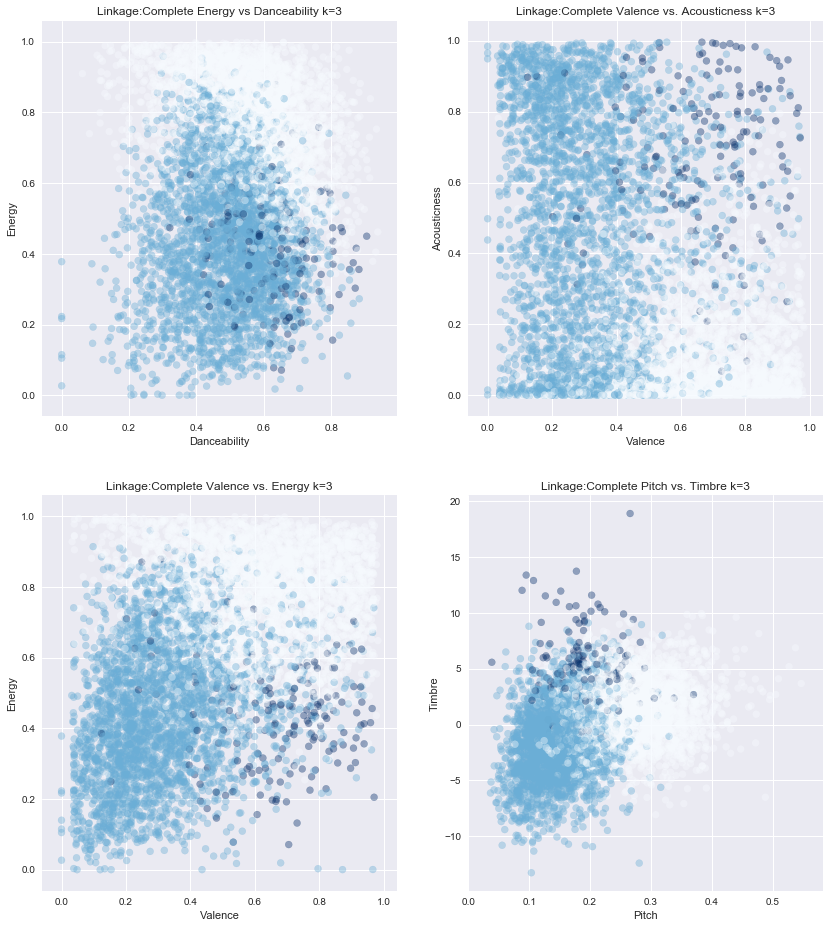

In [64]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('Linkage:Complete Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('Linkage:Complete Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('Linkage:Complete Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['complete_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('Linkage:Complete Pitch vs. Timbre k=3')

plt.savefig('../images/AggComplete_FeaturesClusters_K3.png')

### Visualizing Clusters produced from Agglomerative Clustering (Linkage = Ward)

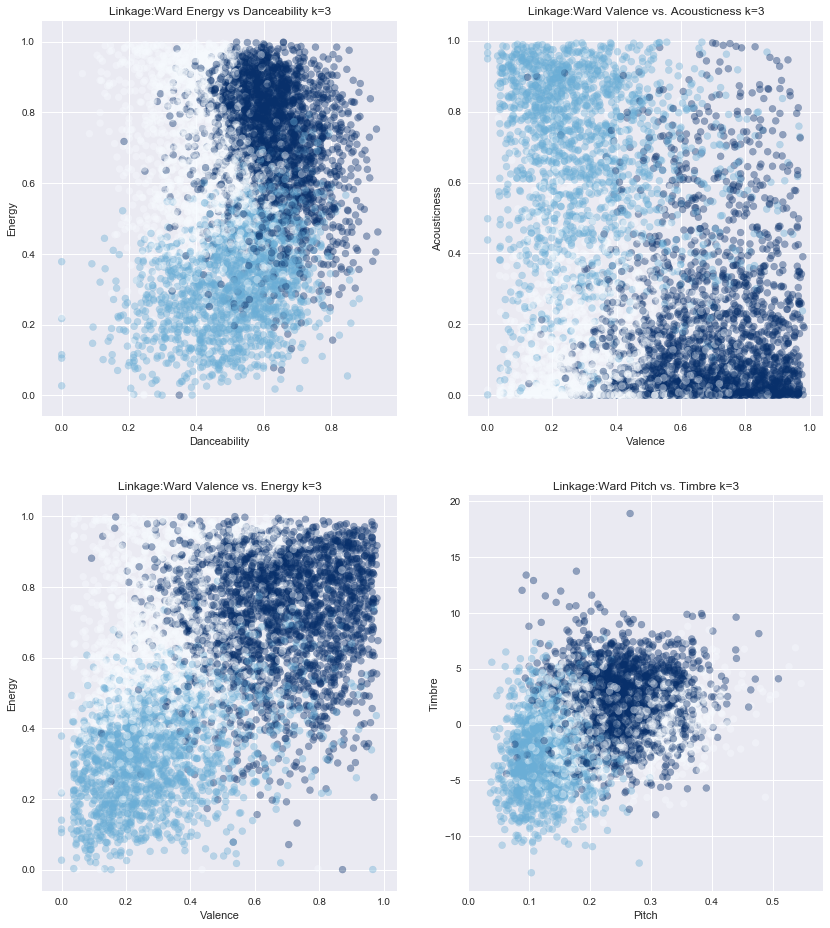

In [65]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('Linkage:Ward Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('Linkage:Ward Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('Linkage:Ward Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['ward_labels'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('Linkage:Ward Pitch vs. Timbre k=3')

plt.savefig('../images/AggWard_FeaturesClusters_K3.png')

#### Summarize Results:

In [225]:
def getClusterSummResults(clustLabel, k=3):
    ''' returns a dataframe with summarized results for the clustering method'''
    
    clust_summ = {'cluster':[],'mSong_tag':[],'count':[], 'Pct Overall Genre': []}
    
    total_msong_pop = songsDF[(songsDF.genre == 'pop')].song_id.count()
    total_msong_country = songsDF[(songsDF.genre == 'country')].song_id.count()
    
    for num in range(k):
        clust_count_cntry = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'country')].song_id.count()
        clust_count_pop   = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'pop')].song_id.count()
    
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('country')
        clust_summ['count'].append(clust_count_cntry)
        clust_summ['Pct Overall Genre'].append(clust_count_cntry/total_msong_country*100)
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('pop')
        clust_summ['count'].append(clust_count_pop)
        clust_summ['Pct Overall Genre'].append(clust_count_pop/total_msong_pop*100)

    
    summDF = pd.DataFrame(clust_summ)
    summDF = summDF[['cluster','mSong_tag','count','Pct Overall Genre']].copy()
    return summDF


KMeansDF = getClusterSummResults('K_cluster_n3')
KMeansDF2 = getClusterSummResults('K_cluster_n2',2)
#AggCompleteDF = getClusterSummResults('complete_labels')
#AggWardDF = getClusterSummResults('ward_labels')


KMeans - K=2

* Cluster 0 - Low Acoustic
* Cluster 1 - High Acoustic

In [226]:
KMeansDF2

cluster mSong_tag  count  Pct Overall Genre
0        0   country   1793          58.157639
1        0       pop   1724          61.615440
2        1   country   1290          41.842361
3        1       pop   1074          38.384560

In [227]:
KMeansDF

cluster mSong_tag  count  Pct Overall Genre
0        0   country    915          29.678884
1        0       pop    894          31.951394
2        1   country   1035          33.571197
3        1       pop    959          34.274482
4        2   country   1133          36.749919
5        2       pop    945          33.774124

__KMeans Clusters__
- 0 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch
- 1 - High Energy, High Danceability, High Valence, High Timbre
- 2 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence




 <br>* *majority of the country songs are classified as cluster 2
 <br>* *majority of the pop songs are classified as cluster 1
 <br>* *cluster 3 appears to be the most common features 'overlap' between country and pop songs 

In [76]:
AggCompleteDF

cluster mSong_tag  count  Pct Overall Genre
0        0   country   1445          46.869932
1        0       pop   1391          49.714081
2        1   country   1528          49.562115
3        1       pop   1351          48.284489
4        2   country    110           3.567953
5        2       pop     56           2.001430

__Agglomerative Linkage: Complete__
- 0 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence
- 1 - High Energy, High Danceability, High Valence, High Timbre
- 2 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch



In [77]:
AggWardDF

cluster mSong_tag  count  Pct Overall Genre
0        0   country    927          30.068115
1        0       pop    890          31.808435
2        1   country    930          30.165423
3        1       pop    751          26.840600
4        2   country   1226          39.766461
5        2       pop   1157          41.350965

__Agglomerative Linkage: Ward__
- 0 - High Energy, High Danceability, High Valence, High Timbre
- 1 - High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence
- 2 - High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch

### Findings:

1) The cluster characteristics produced by the three different cluster methods were similar.  Main clusters can be described with the following features:

- lower energy, high acoustic, lowest valence, low timbre, low pitch
- high energy, low valence, high pitch, low acoustic
- High energy, high danceability, high valence, high timbre

2) With the audio features we were able to collect, none of these features could clearly distinguish a country song from a Pop song, although majority of Country songs are classified under the cluster with (lower energy, high acoustic, lowest valence, low timbre, low pitch), while majority of the Pop songs are classified under the cluster with (high energy, low valence, high pitch, low acoustic).

3) Looking at the scatter plots for the results of the different clustering methods, the results from KMeans appear to have more distinct clusters between the different features which were plotted out.  
